In [283]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd

import numpy.random as npr

from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
from scipy import optimize
from scipy import stats

#import QuantLib as ql
import copy

%matplotlib inline

In [284]:
dir       = 'data/'
file_name = 'grid1_zheb51fo.xlsx'
UX1       = pd.read_excel(dir+file_name, sheet_name='UX1_Index')
UX2       = pd.read_excel(dir+file_name, sheet_name='UX2_Index')

UX1       = UX1.set_index('Date')
UX2       = UX2.set_index('Date')
UX1.sort_index(inplace=True)
UX2.sort_index(inplace=True)

UX1

,PX_LAST,PX_VOLUME
Date,,
2010-01-04,24.8500,3138
2010-01-05,24.4500,1936
2010-01-06,23.5500,1958
2010-01-07,23.1500,1760
2010-01-08,22.5500,2050
...,...,...
2022-01-12,20.9713,76675
2022-01-13,22.0944,82700
2022-01-14,21.7462,102849


Historical data of SPX price found at https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

In [285]:
file_name = 'SPX_HistoricalData.csv'
SPX_price = pd.read_csv(dir+file_name)
SPX_price['Date']                             = pd.to_datetime(SPX_price['Date'],format='%m/%d/%y')
SPX_price                                     = SPX_price.set_index('Date')
SPX_price.sort_index(inplace=True)
SPX_price

,Open,High,Low,Close
Date,,,,
2010-04-01,1171.23,1181.43,1170.69,1178.10
2010-04-05,1178.71,1187.73,1178.71,1187.44
2010-04-06,1186.01,1191.80,1182.77,1189.44
2010-04-07,1188.23,1189.60,1177.25,1182.45
2010-04-08,1181.75,1188.55,1175.12,1186.44
...,...,...,...,...
2022-01-10,4655.34,4673.02,4582.24,4670.29
2022-01-11,4669.14,4714.13,4638.27,4713.07
2022-01-12,4728.59,4748.83,4706.71,4726.35


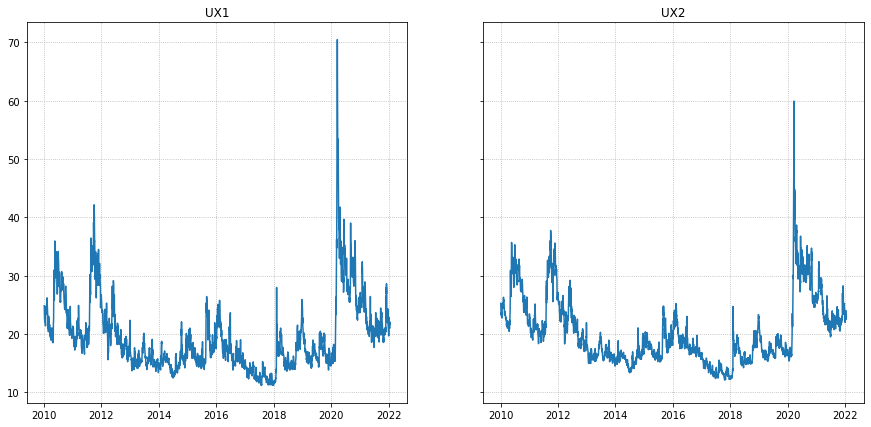

In [286]:
fig,ax = plt.subplots(ncols=2, figsize=(15,7), sharey=True)
ax[0].plot(UX1.index, UX1.PX_LAST)
ax[1].plot(UX2.index, UX2.PX_LAST)
ax[0].set_title('UX1')
ax[1].set_title('UX2')
ax[0].grid(linestyle='dotted')
ax[1].grid(linestyle='dotted')
plt.show()

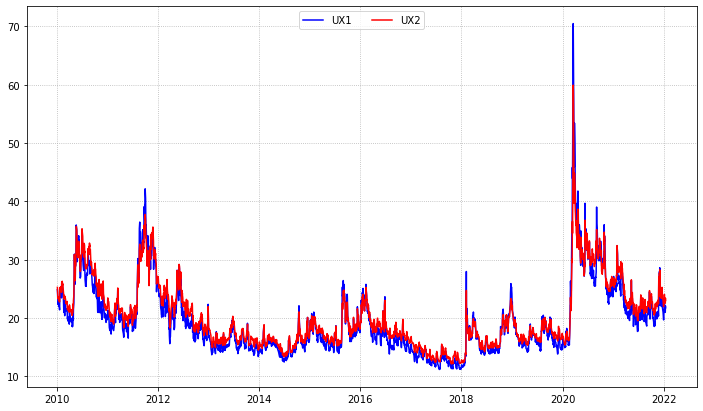

In [287]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(UX1.index, UX1.PX_LAST, label='UX1', color='blue')
ax.plot(UX2.index, UX2.PX_LAST, label='UX2', color='red')
ax.legend(loc='upper center', ncol=2)
ax.grid(linestyle='dotted')
plt.show()

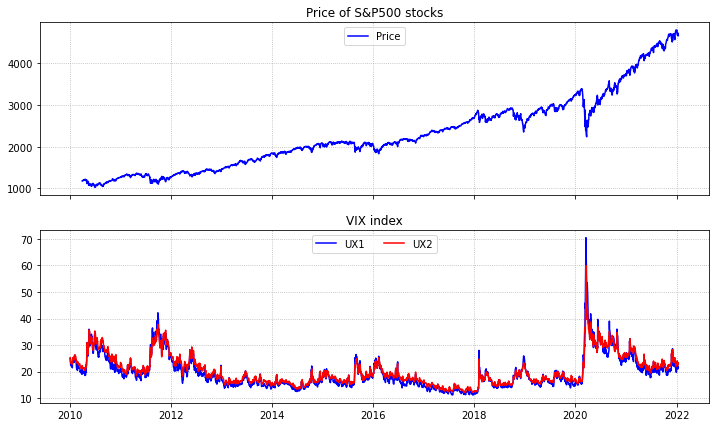

In [288]:
fig,ax = plt.subplots(nrows=2,figsize=(12,7), sharex=True)
ax[0].plot(SPX_price.index, SPX_price.Close, label='Price', color='blue')
ax[0].legend(loc='upper center', ncol=2)
ax[0].grid(linestyle='dotted')
ax[0].set_title('Price of S&P500 stocks')

ax[1].plot(UX1.index, UX1.PX_LAST, label='UX1', color='blue')
ax[1].plot(UX2.index, UX2.PX_LAST, label='UX2', color='red')
ax[1].legend(loc='upper center', ncol=2)
ax[1].grid(linestyle='dotted')
ax[1].set_title('VIX index')
plt.show()

## Black-Scholes Model

In [289]:
SPX_price['LogReturn'] = np.log(SPX_price['Close']/SPX_price['Close'].shift(1))

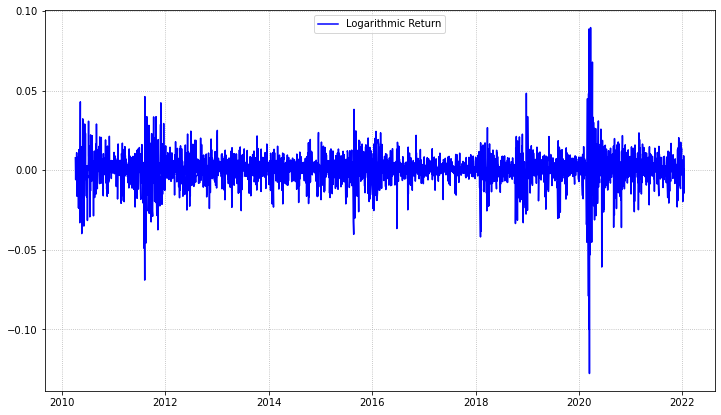

In [290]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(SPX_price.index, SPX_price.LogReturn, label='Logarithmic Return', color='blue')
ax.legend(loc='upper center', ncol=2)
ax.grid(linestyle='dotted')
#ax.set_title('Price of S&P500 stocks')
plt.show()

Expected return:		0.1257
Volatility:     		0.0155


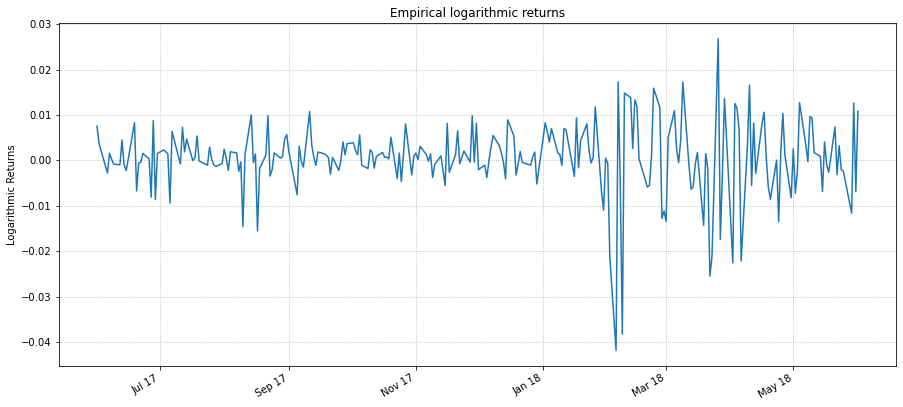

In [291]:
start             = '2017-06-01'
stop              = '2018-06-01'
mask              = (SPX_price.index >= start) & (SPX_price.index <= stop)
SPX_price_window1 = copy.deepcopy(SPX_price[mask])
dt                = 1/SPX_price_window1.shape[0]
Expected_Return   = (2*SPX_price_window1['LogReturn'].mean() + 2*SPX_price_window1['LogReturn'].var()*dt) / (2*dt)
Volatility        = SPX_price_window1['LogReturn'].var()/dt

print('Expected return:\t\t%.4f'% Expected_Return)
print('Volatility:     \t\t%.4f'% Volatility)

fig, ax          = plt.subplots(figsize=(15,7))
SPX_price_window1['LogReturn'].plot(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Logarithmic Returns')
ax.set_title('Empirical logarithmic returns')
ax.grid(linestyle='dotted')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.show()

R2 			=		 0.9427268966012181 
R 			=		 0.9709412426100861

Covariance matrix:
 [[1.         0.25517984]
 [0.25517984 1.        ]]

n degrees of freedom 	=		 10

chi2 			=		 139.37028213530783
p-value 		=		 0.0


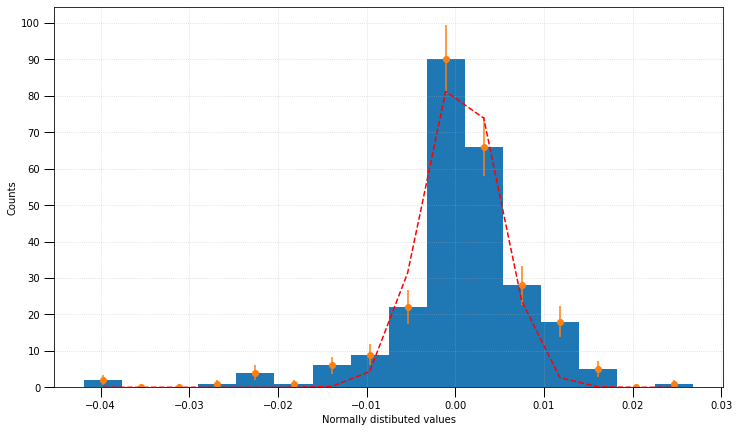

In [292]:
b                 = np.histogram_bin_edges(SPX_price_window1.LogReturn.dropna(), bins='sqrt')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(SPX_price_window1.LogReturn, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

def gaussian(x, N, mu, sig):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [100,Expected_Return, Volatility])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r' )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err])
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

In [293]:
n                 = 4 # number of simulated paths

start             = '2018-06-01'
stop              = '2019-06-01'
mask              = (SPX_price.index >= start) & (SPX_price.index <= stop)
SPX_price_window2 = copy.deepcopy(SPX_price[mask])

z                 = np.sqrt(dt) * npr.normal(0,1,(n, SPX_price_window2.shape[0])) # stochastic variable
S0                = SPX_price_window2.loc[start,'Close']

for k in range(n):
    col = 'Price_Sim'+str(k)
    xt = np.array([0])
    for i in range(SPX_price_window2.shape[0]-1):
        xt = np.append(xt, xt[i] + (Expected_Return - Volatility**2/2)*dt + Volatility*(z[k][i+1]+z[k][i])) # not sure about this (if it is + or -)

    SPX_price_window2[col] = np.exp(xt)*S0

Text(0.5, 1.0, 'Price of S&P500 stocks')

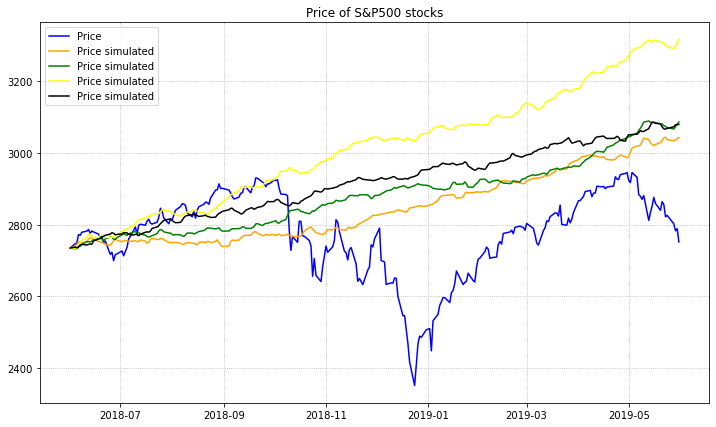

In [294]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(SPX_price_window2.index, SPX_price_window2.Close, label='Price', color='blue')
ax.plot(SPX_price_window2.index, SPX_price_window2.Price_Sim0, label='Price simulated', color='orange')
ax.plot(SPX_price_window2.index, SPX_price_window2.Price_Sim1, label='Price simulated', color='green')
ax.plot(SPX_price_window2.index, SPX_price_window2.Price_Sim2, label='Price simulated', color='yellow')
ax.plot(SPX_price_window2.index, SPX_price_window2.Price_Sim3, label='Price simulated', color='black')
ax.legend(loc='upper left')
ax.grid(linestyle='dotted')
ax.set_title('Price of S&P500 stocks')

## Heston Model

In [295]:
# historical data for estimation of parameters
start             = '2014-03-01'
stop              = '2014-05-01'
mask              = (UX1.index >= start) & (UX1.index < stop)
UX1_window1       = copy.deepcopy(UX1[mask])
UX2_window1       = copy.deepcopy(UX2[mask])

# 'future' data to compare with
start             = '2014-05-01'
stop              = '2014-07-01'
mask              = (UX1.index >= start) & (UX1.index < stop)
UX1_window2       = copy.deepcopy(UX1[mask])
UX2_window2       = copy.deepcopy(UX2[mask])

# 'future' prices
start             = '2014-05-01'
stop              = '2014-07-01'
mask              = (SPX_price.index >= start) & (SPX_price.index < stop)
SPX_price_window2 = copy.deepcopy(SPX_price[mask])

In [296]:
# 'today' price and volatility
S0    = SPX_price_window2.loc[start,   'Close']
UX10  = UX1_window2.loc[      start, 'PX_LAST']
UX20  = UX2_window2.loc[      start, 'PX_LAST']

Vt    = UX1_window1.PX_LAST.values**2

# parameters
# according to bibliography/parameters_estimation.pdf
T      = 1
Npaths = 100
steps  = 252

delta = 1 # don't know how to find it

n     = len(Vt)

P     = (1/n   *sum((Vt[i]*Vt[i-1])**.5 for i in range(1,n)) -
         1/n**2*sum((Vt[i]/Vt[i-1])**.5 for i in range(1,n)) *
         sum(Vt[i-1] for i in range(1,n))) / (delta/2 - delta/(2*n**2) * sum(Vt[i-1] for i in range(1,n)))

k     = 2/delta * (1 + P*delta/(2*n)*sum(1/Vt[i-1] for i in range(1,n)) -
                   1/n*sum((Vt[i]/Vt[i-1])**0.5    for i in range(1,n)))

sigma = (4/(delta*n)*sum(Vt[i]**.5 - Vt[i-1]**.5 -
                         delta/(2*Vt[i-1]**.5)*(P-k*Vt[i-1]) for i in range(1,n)))**.5

theta = (P+sigma**2/2)/k

rho   = -.7890 # don't know how to find it
r     = 2.17 # don't know how to find it

e1    = npr.normal(0,1,(SPX_price_window2.shape[0],1))
e2    = npr.normal(0,1,(SPX_price_window2.shape[0],1))
eV    = e1
eS    = rho*e1 + np.sqrt(1-rho**2)*e2

In [297]:
# 'today' price and volatility
S0    = SPX_price_window2.loc[start,   'Close']
UX10  = UX1_window2.loc[      start, 'PX_LAST']
UX20  = UX2_window2.loc[      start, 'PX_LAST']

Vt1   = UX1_window1.PX_LAST.values**2

# parameters
# according to bibliography/parameters_estimation.pdf
T      = 1
Npaths = 100
steps  = UX1_window2.shape[0]

delta = 1 # don't know how to find it

n1     = len(Vt1)

P1     = (1/n   *sum((Vt1[i]*Vt1[i-1])**.5 for i in range(1,n)) -
          1/n**2*sum((Vt1[i]/Vt1[i-1])**.5 for i in range(1,n)) *
          sum(Vt1[i-1] for i in range(1,n))) / (delta/2 - delta/(2*n**2) * sum(Vt1[i-1] for i in range(1,n)))

k1     = 2/delta * (1 + P*delta/(2*n)*sum(1/Vt1[i-1] for i in range(1,n)) -
                    1/n*sum((Vt1[i]/Vt1[i-1])**0.5   for i in range(1,n)))

sigma1 = (4/(delta*n)*sum(Vt1[i]**.5 - Vt1[i-1]**.5 -
                          delta/(2*Vt1[i-1]**.5)*(P-k*Vt1[i-1]) for i in range(1,n)))**.5

theta1 = (P+sigma1**2/2)/k

rho    = -.7890 # don't know how to find it
r      = 2.17 # don't know how to find it

e1     = npr.normal(0,1,(SPX_price_window2.shape[0],1))
e2     = npr.normal(0,1,(SPX_price_window2.shape[0],1))
eV     = e1
eS     = rho*e1 + np.sqrt(1-rho**2)*e2

In [298]:
Vt2   = UX2_window1.PX_LAST.values**2

n2     = len(Vt2)

P2     = (1/n   *sum((Vt2[i]*Vt2[i-1])**.5 for i in range(1,n)) -
          1/n**2*sum((Vt2[i]/Vt2[i-1])**.5 for i in range(1,n)) *
          sum(Vt2[i-1] for i in range(1,n))) / (delta/2 - delta/(2*n**2) * sum(Vt2[i-1] for i in range(1,n)))

k2     = 2/delta * (1 + P*delta/(2*n)*sum(1/Vt2[i-1] for i in range(1,n)) -
                    1/n*sum((Vt2[i]/Vt2[i-1])**0.5   for i in range(1,n)))

sigma2 = (4/(delta*n)*sum(Vt2[i]**.5 - Vt2[i-1]**.5 -
                          delta/(2*Vt2[i-1]**.5)*(P-k*Vt2[i-1]) for i in range(1,n)))**.5

theta2 = (P+sigma2**2/2)/k

In [299]:
def heston_pde(  S,   T,     r,     k,  theta,
               v_0, rho, sigma, steps, Npaths):
    dt         = T/steps
    size       = (Npaths, steps)
    prices     = np.zeros(size)
    volatility = np.zeros(size)
    S_t        = np.full(Npaths,   S)
    v_t        = np.full(Npaths, v_0)
    for t in range(steps):
        WT = np.sqrt(dt) * np.random.multivariate_normal(np.array( [0,  0]),
                                                         np.array([[1,rho],
                                                                   [rho,1]]),
                                                         size=Npaths)
        S_t         = S_t*np.exp(    (r - 0.5*v_t)*dt +       np.sqrt(v_t)*WT[:,0])
        v_t         = np.abs(v_t + k*(theta - v_t)*dt + sigma*np.sqrt(v_t)*WT[:,1])

        prices[    :,t] = S_t
        volatility[:,t] = v_t

    return prices, volatility

prices1, volatility1 = heston_pde(S0, T, r, k1, theta1, UX10, rho, sigma1, steps, Npaths)
prices2, volatility2 = heston_pde(S0, T, r, k2, theta2, UX10, rho, sigma2, steps, Npaths)

In [300]:
for k in range(Npaths):
    col = 'sim_' + str(k)
    UX1_window2[col] = pd.Series(volatility1[k], index=UX1_window2.index)
    UX2_window2[col] = pd.Series(volatility2[k], index=UX2_window2.index)

UX1_window2['mean_sim'] = (UX1_window2.loc[:, ['sim_' + str(k) for k in range(Npaths)]]).mean(axis=1)
UX2_window2['mean_sim'] = (UX2_window2.loc[:, ['sim_' + str(k) for k in range(Npaths)]]).mean(axis=1)

/tmp/ipykernel_217412/1123934668.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  UX1_window2[col] = pd.Series(volatility1[k], index=UX1_window2.index)
/tmp/ipykernel_217412/1123934668.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  UX2_window2[col] = pd.Series(volatility2[k], index=UX2_window2.index)


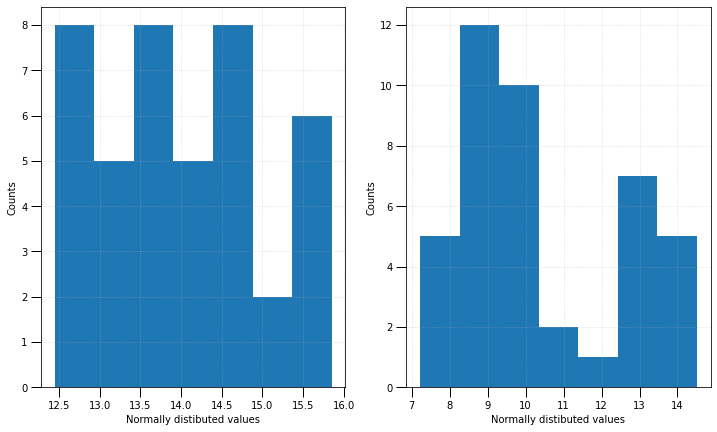

In [301]:
fig, ax           = plt.subplots(ncols=2, figsize=(12, 7))

b                 = np.histogram_bin_edges(UX1_window2.PX_LAST.dropna(), bins='sqrt')
entries, edges, _ = ax[0].hist(UX1_window2.PX_LAST, bins=b)
ax[0].set_ylabel('Counts')
ax[0].set_xlabel("Normally distibuted values")
ax[0].tick_params(which='major', width=1.0)
ax[0].tick_params(which='major', length=10)
ax[0].grid(linestyle='dotted', alpha=0.5)

b                 = np.histogram_bin_edges(UX1_window2.sim_0.dropna(), bins='sqrt')
entries, edges, _ = ax[1].hist(UX1_window2.sim_0, bins=b)
ax[1].set_ylabel('Counts')
ax[1].set_xlabel("Normally distibuted values")
ax[1].tick_params(which='major', width=1.0)
ax[1].tick_params(which='major', length=10)
ax[1].grid(linestyle='dotted', alpha=0.5)

plt.show()

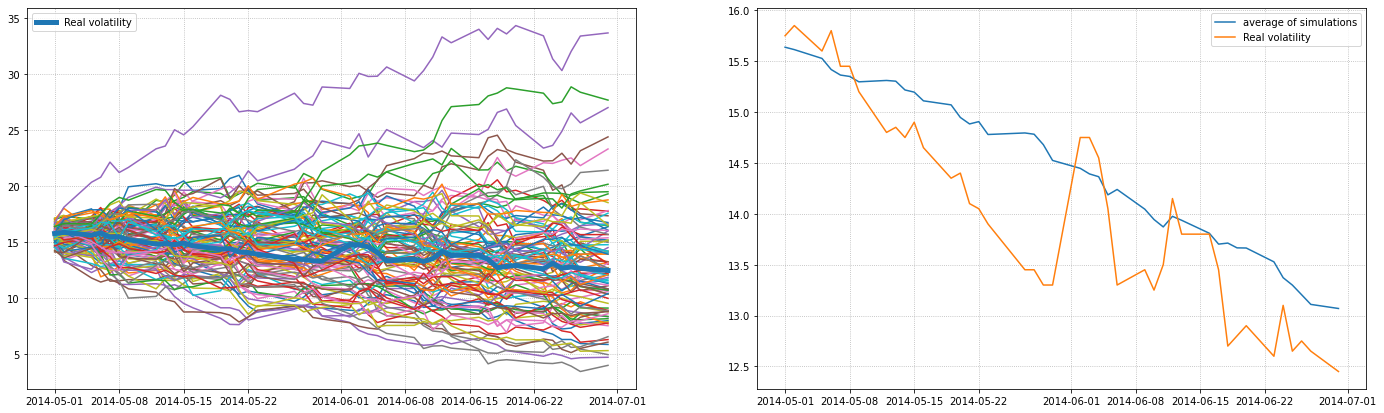

In [302]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

for k in range(Npaths):
    col = 'sim_' + str(k)
    ax[0].plot(UX1_window2.index, UX1_window2[col], label='')
ax[0].plot(UX1_window2.index, UX1_window2.PX_LAST, lw=5, label='Real volatility')
ax[0].grid(linestyle='dotted')
ax[0].legend(loc='best')

ax[1].plot(UX1_window2.index, UX1_window2['mean_sim'], label='average of simulations')
ax[1].plot(UX1_window2.index, UX1_window2.PX_LAST, label='Real volatility')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
plt.show()

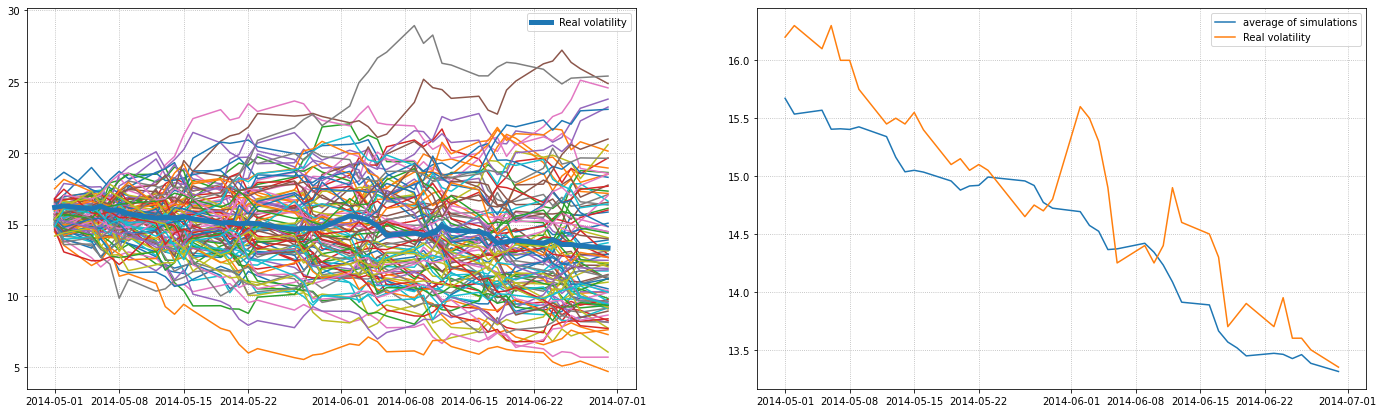

In [303]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

for k in range(Npaths):
    col = 'sim_' + str(k)
    ax[0].plot(UX2_window2.index, UX2_window2[col], label='')
ax[0].plot(UX2_window2.index, UX2_window2.PX_LAST, lw=5, label='Real volatility')
ax[0].grid(linestyle='dotted')
ax[0].legend(loc='best')

ax[1].plot(UX2_window2.index, UX2_window2['mean_sim'], label='average of simulations')
ax[1].plot(UX2_window2.index, UX2_window2.PX_LAST, label='Real volatility')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
plt.show()